# <center> Практика. Статистические тесты в контексте EDA

## <center> Постановка задачи <center>

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

Необходимо:

 - Выяснить, какие факторы влияют на зарплату специалиста Data Scientist.
 - А также ответить на ключевые вопросы HR-агентства:
    - Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
    - Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
    - Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
    - Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

Сразу выставим уровень значимости $\alpha=0.05$.

Ответить на эти вопросы нам помогут данные из датасета Data Science Job Salaries” (kaggle.com)

Данные содержат следующие столбцы:

* work_year	Год - в котором была выплачена зарплата.  
* experience_level - Опыт работы на этой должности в течение года:
    - EN — Entry-level/Junior;
    - MI — Mid-level/Intermediate;
    - SE — Senior-level/Expert;
    - EX — Executive-level/Director.
* employment_type - Тип трудоустройства для этой роли:
    - PT — неполный рабочий день;
    - FT — полный рабочий день;
    - CT — контракт;
    - FL — фриланс.
* job_title - Роль, в которой соискатель работал в течение года.
* salary - Общая выплаченная валовая сумма заработной платы.
* salary_currency - Валюта выплачиваемой заработной платы в виде кода валюты ISO 4217.
* salary_in_usd - Зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через fxdata.foorilla.com).
* remote_ratio - Общий объём работы, выполняемой удалённо. Возможные значения:
    - 0 — удалённой работы нет (менее 20 %);
    - 50 — частично удалённая работа;
    - 100 — полностью удалённая работа (более 80 %).
* company_location - Страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166.
* company_size - Среднее количество людей, работавших в компании в течение года:
    - S — менее 50 сотрудников (небольшая компания);
    - M — от 50 до 250 сотрудников (средняя компания);
    - L — более 250 сотрудников (крупная компания).

## Загрузка данных

In [1]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns

import plotly
import plotly.express as px
from scipy.stats import chi2_contingency

# делаем визуальную настройку графиков
sns.set_theme("notebook") 
sns.set_palette("Set2") 

In [2]:
# загружаем датасет
data = pd.read_csv('data/ds_salaries.csv')
data.head()

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


Т.к. у нас есть колонка salary_in_usd, в которой указана зп в долларах, это значительно упрощает дело, то есть не придется приводить зп к одной валюте, значит колонки salary и salary_currency нам не нужны, их можно удалить

In [3]:
data = data.drop(['salary', 'salary_currency'], axis=1)
data.head()

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,US,50,US,L


Отсортируем оставшиеся признаки

Категориальные:
 - experience_level
 - employment_type
 - job_title
 - remote_ratio
 - company_location
 - company_size
 
Количественные:
 - work_year
 - salary_in_usd

In [4]:
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


## <center> Описательный анализ данных <center>

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary_in_usd       607 non-null    int64 
 6   employee_residence  607 non-null    object
 7   remote_ratio        607 non-null    int64 
 8   company_location    607 non-null    object
 9   company_size        607 non-null    object
dtypes: int64(4), object(6)
memory usage: 47.6+ KB


В датасете 607 записей (без пропущенных значений).

Проверим данные на наличие полных дубликатов:

In [7]:
print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))

Количество дубликатов: 0


### ЗП в зависимости от года

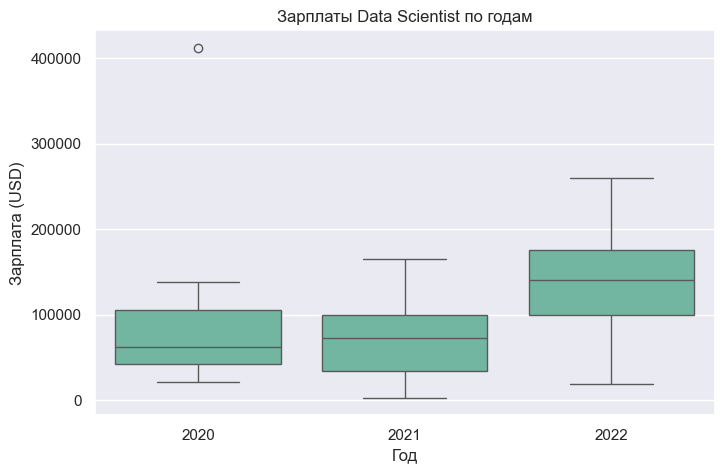

In [6]:
ds = data[data['job_title'] == 'Data Scientist']
plt.figure(figsize=(8,5))
sns.boxplot(data=ds, x="work_year", y="salary_in_usd")
plt.title("Зарплаты Data Scientist по годам")
plt.ylabel("Зарплата (USD)")
plt.xlabel("Год")
plt.show()

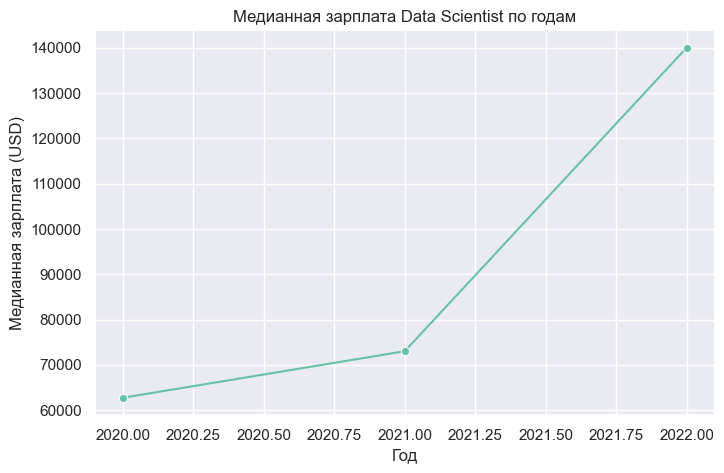

In [7]:
salary_stats = ds.groupby('work_year')['salary_in_usd'].median().reset_index()
plt.figure(figsize=(8,5))
sns.lineplot(data=salary_stats, x="work_year", y="salary_in_usd", marker="o")
plt.title("Медианная зарплата Data Scientist по годам")
plt.ylabel("Медианная зарплата (USD)")
plt.xlabel("Год")
plt.show()

In [8]:
data_agg = data['salary_in_usd'].describe().round(2).to_frame()
data_agg.columns = ['Размер ЗП']
data_agg

,Размер ЗП
count,607.00
mean,112297.87
std,70957.26
min,2859.00
25%,62726.00
50%,101570.00
75%,150000.00
max,600000.00


Визуально можно наблюдать рост зп дата-сайентистов, особенно сильно он выражен в 2022 году

### Зарплаты Data Scientist и Data Engineer в 2022 году

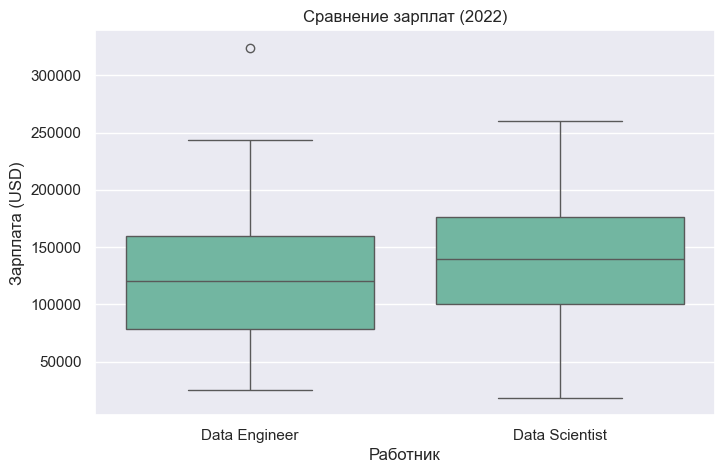

In [9]:
df_2022 = data[data['work_year'] == 2022]
df_roles = df_2022[df_2022['job_title'].isin(['Data Scientist', 'Data Engineer'])]
df_roles.groupby('job_title')['salary_in_usd'].agg('median', 'mean')
plt.figure(figsize=(8,5))
sns.boxplot(data=df_roles, x="job_title", y="salary_in_usd")
plt.title("Сравнение зарплат (2022)")
plt.ylabel("Зарплата (USD)")
plt.xlabel("Работник")
plt.show()

По графику видим, что зп за 2022 год у дата-сайентиста немного выше, чем у дата-инженера

### Соотношение зарплат специалистов Data Scientist в компаниях различных размеров?

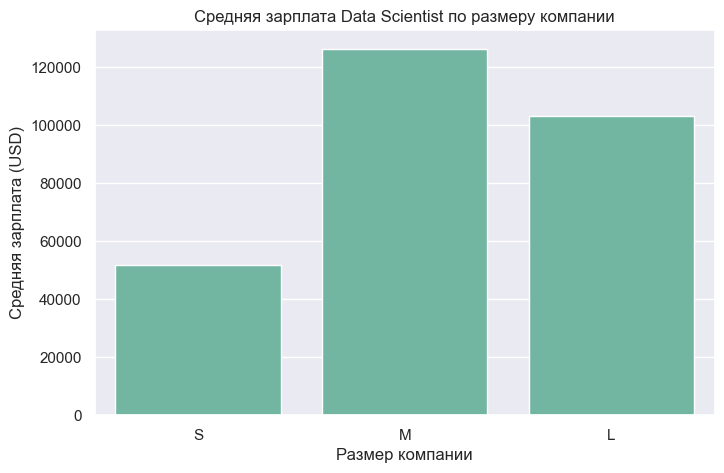

In [10]:
salary_by_size = ds.groupby('company_size')['salary_in_usd'].agg(['median', 'mean']).reset_index()
plt.figure(figsize=(8,5))
sns.barplot(data=salary_by_size, x="company_size", y="mean", order=["S", "M", "L"])
plt.title("Средняя зарплата Data Scientist по размеру компании")
plt.xlabel("Размер компании")
plt.ylabel("Средняя зарплата (USD)")
plt.show()

#### Из графика видим, что средняя зп выше всего в компаниях среднего размера

### Ищем связь между наличием должностей Data Scientist и Data Engineer и размером компании?

Chi2 = 9.56, p-value = 0.0084


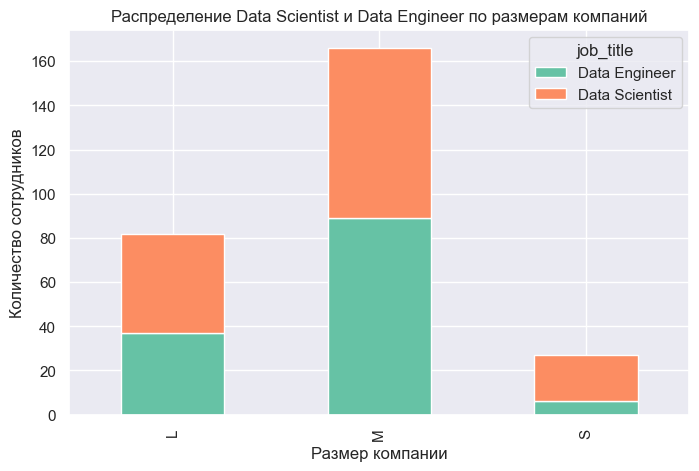

In [11]:
# Отфильтруем должности Data Scientis и Data Engineer
df_filtered = data[data['job_title'].isin(["Data Scientist", "Data Engineer"])]

# Создадим таблицу сопряженности для подсчета количества специалистов каждого типа в компаниях разного размера
contingency_table = pd.crosstab(df_filtered["job_title"], df_filtered["company_size"])

# Проведем тест Хи-квадрат
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi2 = {chi2:.2f}, p-value = {p:.4f}")

contingency_table.T.plot(kind='bar', stacked=True, figsize=(8,5))
plt.title("Распределение Data Scientist и Data Engineer по размерам компаний")
plt.xlabel("Размер компании")
plt.ylabel("Количество сотрудников")
plt.show()


Судя по тесту Хи-квадрат видно, что есть сильная взаимосвязь между наличием должностей Data Scientist и Data Engineer и размером компании

## Статистический анализ данных



In [12]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))
      

### Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплат ($μ_1$) такой же либо меньше, чем в 2020 году ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): размер зарпат ($μ_1$) больше, чем в 2020 году ($μ_2$).

$$ H_1 : μ_1 > μ_2$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Напомним гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [13]:
# Фильтруем значения для дата-сайентистов
ds_df = data[data['job_title'] == 'Data Scientist']

#Группируем зп по годам
salaries_2020 = ds_df[ds_df['work_year'] == 2020]['salary_in_usd']
salaries_2021 = ds_df[ds_df['work_year'] == 2021]['salary_in_usd']
salaries_2022 = ds_df[ds_df['work_year'] == 2022]['salary_in_usd']

# проводим тест Шапиро-Уилка
print('2020 год:')
result = stats.shapiro(salaries_2020)
decision_normality(result[1])

print('2021 год:')
result = stats.shapiro(salaries_2021)
decision_normality(result[1])

print('2022 год:')
result = stats.shapiro(salaries_2022)
decision_normality(result[1])

2020 год:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
2021 год:
p-value = 0.125
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
2022 год:
p-value = 0.327
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «ЗП»? — Количественный.
* Сколько сравниваемых групп? — три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — У нас есть 1 группа с ненормальным распределением.

Чтобы проверить нашу гипотезу, можно использовать тест КРАСКЕЛА — УОЛЛИСА для сравнения 3 независимых групп.

**Проведём тест**

In [18]:
# проводим тест
_, p = stats.kruskal(salaries_2020, salaries_2021, salaries_2022)
print('p-value = {:.3f}'.format(p))

if p < 0.05:
    print("Есть статистически значимый рост зарплат по годам, отвергаем нулевую гипотезу")
else:
    print("Статистически значимых различий нет")

p-value = 0.000
Есть статистически значимый рост зарплат по годам, отвергаем нулевую гипотезу


**Вывод**

Наблюдается рост ЗП дата-сайентистов по годам

### Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?


**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер ЗП дата-сайентистов ($μ_1$) равен размеру зп дата инженеров ($μ_2$).

$$ H_0 : μ_1 = μ_2$$

*Альтернативная гипотеза* ($H_1$): размер ЗП дата-сайентистов ($μ_1$) не равен размеру зп дата инженеров ($μ_2$).
$$ H_1 : μ_1 \neq μ_2$$




**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [19]:
# зп у дата сайентистов и дата инженеров
ds = data[data['job_title'] == 'Data Scientist']['salary_in_usd']
de = data[data['job_title'] == 'Data Engineer']['salary_in_usd']

# проводим тест Шапиро-Уилка
print('Дата сайентисты:')
result = stats.shapiro(ds)
decision_normality(result[1])

print('Дата инженеры:')
result = stats.shapiro(de)
decision_normality(result[1])

Дата сайентисты:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Дата инженеры:
p-value = 0.010
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «salary_in_usd»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать U-критерий Манна — Уитни.

**Проведём тест**


In [20]:
# проводим тест
_, p = stats.mannwhitneyu(ds, de)

print('p-value = {:.3f}'.format(p))

# Интерпретируем данные
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.467
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**

Размеры ЗП у дата сайентистов и дата инженеров различаются

### Равны ли ЗП дата сайентистов в компаниях различных размеров?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: размер ЗП равен в компаниях размером: S-менее маленькая компания ($μ_1$), M - средняя компания ($μ_2$), L - большая компания ($μ_3$)

$$ H_0 : μ_1 = μ_2 = μ_3 $$

*Альтернативная гипотеза*: размер ЗП не равен в компаниях размером: S-менее маленькая компания ($μ_1$), M - средняя компания ($μ_2$), L - большая компания ($μ_3$)

$$ H_1 : μ_1 \neq μ_2 \neq μ_3 $$


**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [23]:
# Сортируем дата сайентистов
df_ds = data[data['job_title'] == 'Data Scientist']

# зп по размеру компании
s_company = df_ds[df_ds['company_size'] == 'S']['salary_in_usd']
m_company = df_ds[df_ds['company_size'] == 'M']['salary_in_usd']
l_company = df_ds[df_ds['company_size'] == 'L']['salary_in_usd']

# проводим тест Шапиро-Уилка
print('Маленькая компания:')
result = stats.shapiro(s_company)
decision_normality(result[1])

print('Средняя компания:')
result = stats.shapiro(m_company)
decision_normality(result[1])

print('Большая компания:')
result = stats.shapiro(l_company)
decision_normality(result[1])


Маленькая компания:
p-value = 0.189
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Средняя компания:
p-value = 0.639
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Большая компания:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «salary_in_usd»? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки нашей гипотезы можно использовать критерий Краскела-Уоллиса

**Проведём тест**

In [24]:
# Проводим тест 
_, p = stats.kruskal(s_company, m_company, l_company)

print('p-value = {:.3f}'.format(p))

# Интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


**Вывод**

ЗП дата сайентистов в компаниях разных размеров не равны

### Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: между наличием должностей и размером компании нет связи

*Альтернативная гипотеза*: между наличием должностей и размером компании есть связь


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Пол»? — Категориальный.
* Сколько сравниваемых групп? — Две.
* Проверяется независимость групп? — Да.

Для проверки нашей гипотезы можно использовать критерий ${\chi}^2$ (хи-квадрат).

**Проведём тест**

In [30]:
# Таблица с подсчётом количества сотрудников по должности и размеру компании
filtered_df = data[data['job_title'].isin(['Data Scientist', 'Data Engineer'])]

contingency_table = pd.crosstab(filtered_df['job_title'], filtered_df['company_size'])
print(contingency_table)

company_size     L   M   S
job_title                 
Data Engineer   37  89   6
Data Scientist  45  77  21


In [31]:
# проводим тест
_, p, _, _ = stats.chi2_contingency(contingency_table)
decision_hypothesis(p)

p-value = 0.008
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Существует статистически значимая взаимосвязь между размером компании и наличием должности

## Итоговые результаты исследования

*   Наблюдается рост ЗП дата-сайентистов по годам
*   Размеры ЗП у дата сайентистов и дата инженеров различаются
*   ЗП дата сайентистов в компаниях разных размеров не равны
*   Существует статистически значимая взаимосвязь между размером компании и наличием должности